<a href="https://colab.research.google.com/github/TQA-task/AHJL/blob/main/AHJL_TaskA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prerequisites**

In [ ]:
pip install -U sentence-transformers

In [ ]:
pip install snowballstemmer

In [ ]:
pip install Arabic-Stopwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
! git clone https://gitlab.com/bigirqu/quran-qa-2023.git

fatal: destination path 'quran-qa-2023' already exists and is not an empty directory.


In [ ]:
!pip install pytrec-eval

In [ ]:
pip install striprtf

In [ ]:
pip install openai

In [ ]:
pip install -U scikit-learn beautifulsoup4

In [ ]:
pip install tiktoken

In [ ]:
!pip install tenacity
!pip install pandas

In [ ]:
pip install -U deep-translator

# **Baseline code**

In [ ]:
import json
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_index(index_path):
    try:
        index = pt.IndexFactory.of(index_path)
        print("Index was loaded successfully from this path: ", index_path)
        return index
    except Exception as e:
        print('Cannot load the index, check exception details {}'.format(e))
        return []


# read file based on its extension (tsv or xlsx)
def read_file(input_file, sep="\t", names = ""):
    if input_file.endswith(".xlsx"):
        df = pd.read_excel(input_file)
    else:
        if names != "":
            df = pd.read_csv(input_file, sep=sep, names=names,encoding="utf-8")
        else:
            df = pd.read_csv(input_file, sep=sep,encoding="utf-8")
    return df

In [ ]:
#ref:https://www.programcreek.com/python/?code=Lab41%2Faltair%2Faltair-master%2Faltair%2Futil%2Fnormalize_text.py
from bs4 import BeautifulSoup
import re
import warnings
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

# Regular expressions to remove web links and only keep letter characters
link_re = re.compile(r'\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')
letter_re = re.compile(r"[^a-zA-Z]")
letter_number_re = re.compile(r"[^0-9a-zA-Z]")

# Use Python 3.0 keyword list (keyword.kwlist) in lower case as stop word candidates for code
python_stop_words = ['false', 'none', 'true', 'and', 'as', 'assert', 'break', 'class', 'continue', 'def', \
              'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', \
              'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', \
              'with', 'yield']

def normalize_text(raw_text, remove_stop_words=False, only_letters=False, return_list=False, remove_one_char_words=False, **kwargs):
    '''
    Algorithm to convert raw text to a return a clean text string
    Method modified from code available at:
    https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
    Args:
        raw_text: Original text to clean and normalize
        remove_stop_words: Boolean value to trigger removal of stop words
        only_letters: Boolean value to trigger removal of characters that are not letters
        return_list: Boolean value to trigger return value as a list of words
        remove_one_char_words: Boolean value to trigger removal of words that are only a single character
    Returns:
        clean_text: Either a string or a list of words that has been filtered based on function parameters.

    '''
    # Remove web links
    clean_text = link_re.sub('', raw_text)

    # Remove HTML
    # Suppress UserWarnings from BeautifulSoup due to text with tech info (ex: code, directory structure)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        clean_text = BeautifulSoup(clean_text, "lxml").get_text()

    # Only keep letters or keep letters and numbers
    if only_letters:
        clean_text = letter_re.sub(" ", clean_text)
    else:
        clean_text = letter_number_re.sub(" ",clean_text)

    # Convert to lower case, split into individual words
    clean_text = clean_text.lower().split()

    # If numbers are allowed in words, remove candidate words that only contain numbers
    if not only_letters:
        clean_text = [w for w in clean_text if not all(i.isdigit() for i in w)]

    # Remove stop words
    if remove_stop_words:
        clean_text = [w for w in clean_text if not w in python_stop_words]
        clean_text = [w for w in clean_text if not w in ENGLISH_STOP_WORDS]

    # Remove words that are only a single character in length
    if remove_one_char_words: clean_text = [w for w in clean_text if len(w)>1]

    # Return as string or list based on parameters
    if return_list:
        return clean_text
    else:
        return " ".join(clean_text)

In [ ]:
from snowballstemmer import stemmer
import arabicstopwords.arabicstopwords as ar_stp

# arabic stemmer
ar_stemmer = stemmer("arabic")

# remove arabic stop words
def ar_remove_stop_words(sentence):
    terms=[]
    stopWords= set(ar_stp.stopwords_list())
    for term in sentence.split() :
        if term not in stopWords :
            terms.append(term)
    return " ".join(terms)


# normalize the arabic text
def normalize_arabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)

# stem the arabic text
def ar_stem(sentence):
    return " ".join([ar_stemmer.stemWord(i) for i in sentence.split()])


# apply all preprocessing steps needed for Arabic text
def preprocess_arabic(text):
    #text = normalize_arabic(text)
    #text = ar_stem(text)
    text = ar_remove_stop_words(text)

    return text

In [ ]:
preprocess_arabic("في سورة المجادلة قال الله تعالى ""إنما النجوى من الشيطان"" مع أن التناجي يمكن أن يكون بالبر والتقوى وليس مقتصرا على الإثم والعدوان. فلماذا نهانا الله عن النجوى في بعض الآيات؟")

'سورة المجادلة قال الله تعالى النجوى الشيطان التناجي يمكن يكون بالبر والتقوى مقتصرا الإثم والعدوان. فلماذا نهانا الله النجوى الآيات؟'

#**Question and Verses Prepration**
[Reference](https://quranenc.com/ar/home)

**Load the Thematic_QPC**

In [ ]:
import pandas as pd

thematic_QPC = pd.read_csv("/content/quran-qa-2023/Task-A/data/Thematic_QPC/QQA23_TaskA_QPC_v1.1.tsv",sep="\t",encoding="utf-8", header=None)

thematic_QPC.columns = ["docno", "aya"]

# Add a new column 'd_id' with the number of the index
thematic_QPC['docid'] = thematic_QPC.index

#Convert thematic_QPC to string list
thematic_QPC_translations_list = thematic_QPC.astype(str).values.tolist()
thematic_QPC_translations_list[0]


['1:1-4',
 'بسم الله الرحمن الرحيم. الحمد لله رب العالمين. الرحمن الرحيم. مالك يوم الدين.',
 '0']

**Load the Holy Quraan full English Translation**

In [ ]:
#Load all the translations of the quraan verses
quran_translations_list = load_jsonl('/content/drive/MyDrive/extracted_data_df.jsonl')

#Define it as a list of strings
quran_translations_Stringlist = []
for record in quran_translations_list:
 quran_translations_Stringlist.append(str(record))

#Convert quran_translations_Stringlist into list of only translation strings
only_translations_Stringlist = []
for item in quran_translations_list:
    only_translations_Stringlist.append(str(item['translation']))

print(len(only_translations_Stringlist))

Loaded 6236 records from /content/drive/MyDrive/extracted_data_df.jsonl
6236


# **Question Pre-processing**

**Translate all the questions to English** using OpenAI API (model: gpt-3.5-turbo)

In [ ]:
import openai
import os
import pandas as pd
from striprtf.striprtf import rtf_to_text
import time


with open('/content/drive/MyDrive/openai_ak.txt', 'r', encoding='utf-8') as file:
    openai_ak = file.read()

openai.api_key = f"{openai_ak}"

#Load Question File
questions_file = pd.read_csv("/content/quran-qa-2023/Task-A/data/QQA23_TaskA_test.tsv",sep="\t",encoding="utf-8", header=None)
questions_list = questions_file.values.tolist()

full_question_file = []

# Iterate over the 'questions_file' list to add translation of the question
for index, row in questions_file.iterrows():
    qid = row[0]
    query = str(row[1])


    response = openai.ChatCompletion.create(
           model="gpt-3.5-turbo",
           messages=[
              {
                "role": "system",
                "content": "You will be provided with a sentence in Arabic, and your task is to translate it into English."
              },
              {
                "role": "user",
                "content": normalize_text(query)
              },
              {
                "role": "assistant",
                "content": ""
              }
            ],
            temperature=0,
            max_tokens=256,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
     )

    output = str(response)
    start_pos = output.find('"content": "') + len('"content": "')
    end_pos = output.find('"', start_pos)
    question = output[start_pos:end_pos]

    data = {'qid': qid, 'query': query, 'query_en': question}
    full_question_file.append(data)

print(full_question_file)
dump_jsonl(full_question_file, "/content/drive/MyDrive/full_questions_file_test_gpt.jsonl")

[{'qid': 500, 'query': 'من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم؟', 'query_en': 'What did Allah, glorified and exalted be He, save our master Ibrahim from?'}, {'qid': 502, 'query': 'ما الدلائل على أن الانبياء والرسل لا يعلمون الغيب؟', 'query_en': 'What are the evidences that prophets and messengers do not know the unseen?'}, {'qid': 504, 'query': 'أين يقع الكهف الذي أوى إليه فتية الكهف؟', 'query_en': 'Where is the cave where the young men sought refuge?'}, {'qid': 505, 'query': 'ما الدلائل على أن القرآن أُنزل لجميع الناس أو جميع الأمم والشعوب؟', 'query_en': 'What evidence is there that the Quran was revealed for all people or all nations and peoples?'}, {'qid': 508, 'query': 'مع ازدياد عدد سكان الارض، هل يجب أن نقلق أو نخاف من عدم كفاية مصادر الغذاء والرزق؟', 'query_en': "With the increase in the world's population, should we be worried or afraid of the insufficiency of food and sustenance resources?"}, {'qid': 510, 'query': 'اتفاقية ""سيداو"" تقول لا يُسمح للرجل بتعدد الزوجات. كيف

NameError: ignored

**Paraphrase the english questions** using OpenAI API (model: gpt-3.5-turbo)

In [ ]:
#Iterate over the 'questions_file' list to add translation of the question
import os
import openai
import time


with open('/content/drive/MyDrive/openai_ak.txt', 'r', encoding='utf-8') as file:
    openai_ak = file.read()

openai.api_key = f"{openai_ak}"

full_question_file = load_jsonl("/content/drive/MyDrive/full_questions_file_test_gpt.jsonl")
full_Paraphrased_questions_file = []

# Iterate over the 'questions_file' list to add translation of the question
for index, row in enumerate(full_question_file):
    qid = row['qid']
    query = row['query']
    query_en = row['query_en']
    query_en_version = []
    query_en_version.append(query_en)
    for i in range(3):
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                      {
                        "role": "system",
                        "content": "You will be provided with an English question, and your task is to paraphrase it."
                      },
                      {
                        "role": "user",
                        "content": normalize_text(query_en)
                      }
            ],
            temperature=0.9,
            max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        output = str(response)
        start_pos = output.find('"content": "') + len('"content": "')
        end_pos = output.find('"', start_pos)
        query_en_version.append(output[start_pos:end_pos])

    #print("query_en_versions", query_en_version)
    data = {'qid': qid, 'query': query, 'query_en': query_en, 'query_en_versions': query_en_version }
    full_Paraphrased_questions_file.append(data)

print(full_Paraphrased_questions_file)
dump_jsonl(full_Paraphrased_questions_file, "/content/drive/MyDrive/full_Paraphrased_questions_gpt_test_data_file.jsonl")

Loaded 52 records from /content/drive/MyDrive/full_questions_file_test_gpt.jsonl
[{'qid': 500, 'query': 'من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم؟', 'query_en': 'What did Allah, glorified and exalted be He, save our master Ibrahim from?', 'query_en_versions': ['What did Allah, glorified and exalted be He, save our master Ibrahim from?', 'From what did Allah, praised and elevated be He, rescue our honored Ibrahim?', 'From what did Allah, praised and elevated be He, deliver our beloved prophet Ibrahim?', 'From what did Allah, praised and elevated is He, rescue our master Ibrahim?']}, {'qid': 502, 'query': 'ما الدلائل على أن الانبياء والرسل لا يعلمون الغيب؟', 'query_en': 'What are the evidences that prophets and messengers do not know the unseen?', 'query_en_versions': ['What are the evidences that prophets and messengers do not know the unseen?', 'What evidence supports the idea that prophets and messengers are not aware of the unseen?', 'What proof is there that prophets and messeng

#**IR using the following Retrieval Pipeline**

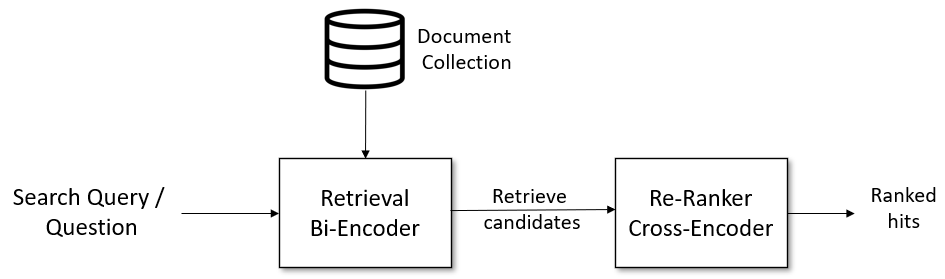

[Resource](https://www.sbert.net/examples/applications/information-retrieval/README.html)

In [ ]:
import ast
def retrieve_passage(record):
    record_dict = ast.literal_eval(record)
    sura = record_dict['sura']
    sura = int(sura)
    verse = record_dict['aya']
    verse = int(verse)
    translation = record_dict['translation']

    for index, item in thematic_QPC.iterrows():
          surah = item['docno'].split(':')[0]
          surah = int(surah)
          start_aya, end_aya = item['docno'].split(':')[1].split('-')
          start_aya = int(start_aya)
          end_aya = int(end_aya)
          if surah == sura:
             if start_aya <= verse <= end_aya:
                  return item['docid'],item['docno']

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

bi_encoder = SentenceTransformer('msmarco-distilbert-base-tas-b') #msmarco-distilbert-base-v4
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2') #"cross-encoder/ms-marco-MiniLM-L-12-v2",

corpus = only_translations_Stringlist
corpus_embeddings = bi_encoder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
def search_crossEncoder(query):
    docnos = []
    scores = []
    docids = []
    unique_docids = set()

    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)

    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=10)
    hits = hits[0]

    cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)

    highest_score = None
    for i, hit in enumerate(hits[0:10]):
       docid, docno = retrieve_passage(quran_translations_Stringlist[hit['corpus_id']])
       score = hit['cross-score']

       if i==0:
        highest_score=hit['cross-score']

       if highest_score < -5:
        docnos.append('-1')
        scores.append(round(score, 2))
        docids.append("")
        break

       elif highest_score >= 0 or score >=0:
        if docid not in unique_docids:
            docnos.append(docno)
            scores.append(round(score, 2))
            docids.append(docid)
            unique_docids.add(docid)

       elif score >= -5 and docid not in unique_docids:
            docnos.append(docno)
            scores.append(round(score, 2))
            docids.append(docid)
            unique_docids.add(docid)

    return docids, scores, docnos

In [ ]:
#Run the search over all translated Questions only (without paraphrasing)
for index, record in enumerate(full_questions_file):
    query = record['query_en']
    docnos_list = []
    scores_list = []
    docids_list = []

    scores= []
    docids, scores, docnos = search_crossEncoder(normalize_text(query))

    docnos_list.append(docnos)
    scores_list.append(scores)
    docids_list.append(docids)

    record['docno'] = docnos_list
    record['score'] = scores_list
    record['docid'] = docids_list

    rank_list = [x for x in range(1, len(docnos_list[0]) + 1)]
    record['rank'] = rank_list


print(full_questions_file)

[{'qid': 500, 'query': 'من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم', 'query_en': 'What did God Almighty save our master Abraham?', 'docno': [['29:24-27', '14:35-41', '21:51-68', '60:4-7', '26:52-68', '29:16-18', '26:160-175', '6:74-79']], 'score': [[1.67, 0.62, -1.9, -2.26, -4.66, -4.95, -4.97, -5.85]], 'docid': [[780, 522, 654, 1089, 733, 778, 739, 283]], 'rank': [1, 2, 3, 4, 5, 6, 7, 8]}, {'qid': 502, 'query': 'ما الدلائل على أن الانبياء والرسل لا يعلمون الغيب', 'query_en': 'What are the evidences that the prophets and messengers do not know the unseen?', 'docno': [['5:109-109', '81:15-25', '12:102-107', '72:25-28', '10:18-20', '3:42-44', '9:101-106', '27:59-66', '49:14-18', '23:78-92']], 'score': [[2.65, 1.19, 0.94, 0.79, 0.35, 0.15, -1.55, -2.43, -3.19, -3.86]], 'docid': [[261, 1196, 499, 1150, 426, 117, 413, 751, 1020, 696]], 'rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, {'qid': 504, 'query': 'أين يقع الكهف الذي أوى إليه فتية الكهف', 'query_en': 'Where is the cave that sheltered the

In [ ]:
#Run the search over all translated Questions and its paraphrased versions
for index, record in enumerate(full_paraphrased_questions_file):
    original_query = record['query_en']
    english_query_version_list = record['query_en_versions']
    docnos_list = []
    scores_list = []
    docids_list = []

    for query_en in english_query_version_list:
        scores= []
        docnos= []
        docids=[]

        docids, scores, docnos = search_crossEncoder(normalize_text(query_en))
        docnos_list.append(docnos)
        scores_list.append(scores)
        docids_list.append(docids)

   #Search for the origional query too.
    docids, scores, docnos = search_crossEncoder(normalize_text(original_query))
    docnos_list.append(docnos)
    scores_list.append(scores)
    docids_list.append(docids)

    record['docno'] = docnos_list
    record['score'] = scores_list
    record['docid'] = docids_list

for record in full_paraphrased_questions_file:
   print(record)

{'qid': 500, 'query': 'من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم؟', 'query_en': 'What did Allah, glorified and exalted be He, save our master Ibrahim from?', 'query_en_versions': ['What did Allah, glorified and exalted be He, save our master Ibrahim from?', 'From what did Allah, praised and elevated be He, rescue our honored Ibrahim?', 'From what did Allah, praised and elevated be He, deliver our beloved prophet Ibrahim?', 'From what did Allah, praised and elevated is He, rescue our master Ibrahim?'], 'docno': [['30:38-41', '28:68-75', '57:1-6', '37:158-166', '39:60-67', '37:139-148', '40:38-46', '65:4-7', '67:28-30'], ['23:23-30', '37:171-182', '1:1-4', '34:1-2', '45:36-37', '5:9-10', '48:1-4'], ['27:59-66', '33:56-58', '1:1-4', '37:171-182', '39:1-5', '45:36-37', '94:1-4', '5:9-10', '42:1-6', '19:73-76'], ['6:63-67', '37:171-182', '45:36-37', '1:1-4', '4:153-161', '3:145-148'], ['30:38-41', '28:68-75', '57:1-6', '37:158-166', '39:60-67', '37:139-148', '40:38-46', '65:4-7', '67:28-


# **Prepare run file**


In [ ]:
#Result of all Translated Questions only
def update_record(record):
    input_dict = record
    qid = input_dict['qid']
    query = input_dict['query']
    docno_list = input_dict['docno'][0]
    docid_list = input_dict['docid'][0]
    score_list = input_dict['score'][0]
    rank_list = input_dict['rank']

    # Create the new pandas DataFrame
    # qid Q0 docid rank score tag
    rows_list = []
    for i in range(len(docno_list)):
        row_dict = {
            'qid': qid,
            'Q0': 'Q0',
            'docno': docno_list[i],
            'rank': rank_list[i],
            'score': score_list[i],
            'tag': 'SemanticSearch',
        }
        rows_list.append(row_dict)

     # Convert the list of dictionaries to a DataFrame
    updated_record = pd.DataFrame(rows_list)

    # Remove duplicates based on 'docno' and keep the row with the highest score
    updated_record.drop_duplicates(subset='docno', keep='first', inplace=True)

    # Sort the DataFrame by the 'score' column in descending order
    updated_record.sort_values(by='score', ascending=False, inplace=True)

    return updated_record


In [ ]:
#Result of all Translated Questions only
import pandas as pd
from IPython.display import display, HTML

all_data_frames = []

for item in full_questions_file:
    run_file = update_record(item)
    all_data_frames.append(run_file)

combined_data_frame = pd.concat(all_data_frames, ignore_index=True)
# Reset the DataFrame index to the default integer index
combined_data_frame.reset_index(drop=True, inplace=True)
display(HTML(combined_data_frame.to_html()))
combined_data_frame.to_csv("/content/AHJL_run01g.tsv", sep="\t", index=False, header=False)

,qid,Q0,docno,rank,score,tag
0,500,Q0,29:24-27,1,1.67,SemanticSearch
1,500,Q0,14:35-41,2,0.62,SemanticSearch
2,500,Q0,21:51-68,3,-1.90,SemanticSearch
3,500,Q0,60:4-7,4,-2.26,SemanticSearch
4,500,Q0,26:52-68,5,-4.66,SemanticSearch
5,500,Q0,29:16-18,6,-4.95,SemanticSearch
6,500,Q0,26:160-175,7,-4.97,SemanticSearch
7,500,Q0,6:74-79,8,-5.85,SemanticSearch
8,502,Q0,5:109-109,1,2.65,SemanticSearch
9,502,Q0,81:15-25,2,1.19,SemanticSearch


In [ ]:
#Result of all Translated Questions and its paraphrased versions
from IPython.display import display, HTML
import pandas as pd


def print_run_record(data):
    # Initialize lists to store data for the new DataFrame
    full_result = []
    extracted_rows = []

    # Iterate through the sublists within docno, score, docid, and rank
    for i in range(len(data['docno'])):
        docno_sublist = data['docno'][i]
        score_sublist = data['score'][i]
        docid_sublist = data['docid'][i]

        # Iterate through the values in each sublist and create a row for each value
        for j in range(len(docno_sublist)):
            qid = data['qid']
            query = data['query']
            docno_value = docno_sublist[j]
            score_value = score_sublist[j]
            docid_value = docid_sublist[j]

            row_dict = {
                'qid': qid,
                'Q0': "Q0",
                #'docid': docid_value,
                #'query': query,
                'docno': docno_value,
                'score': score_value,
                'tag': "SemanticSearch",
            }
            extracted_rows.append(row_dict)

    df = pd.DataFrame(extracted_rows)

    # Sort & Remove duplicates from the DataFrame
    df_sorted = df.sort_values(by='score', ascending=False)
    df_sorted.drop_duplicates(subset='docno', keep='first', inplace=True)
    df_sorted.reset_index(drop=True, inplace=True)

    # Find the index of the row with -1 in 'docno' column (if exists)
    index_of_minus_one = df_sorted.index[df_sorted['docno'] == '-1'].tolist()

    # Check if the list is not empty (i.e., row with -1 exists)
    if index_of_minus_one:
        # Check if the row with -1 is not the first row
        if index_of_minus_one[0] != 0:
            # Drop all rows with -1 (including the first occurrence) from the DataFrame
            df_sorted = df_sorted.drop(index_of_minus_one)

    # Add a new column 'rank' with values from 1 to the length of the DataFrame
    df_sorted['rank'] = [i + 1 for i in range(len(df_sorted))]
    df_sorted = df_sorted.iloc[:10, :]

    #display(HTML(df_sorted.to_html()))
    return df_sorted

In [ ]:
#Result of all Translated Questions and its paraphrased versions
all_results = []

for row in full_paraphrased_questions_file:
  result = print_run_record(row)
  all_results.append(result)

combined_results = pd.concat(all_results)
#qid Q0 docid rank score tag
desired_order = ['qid', 'Q0', 'docno', 'rank', 'score', 'tag']
combined_results = combined_results[desired_order]
# Reset the DataFrame index to the default integer index
combined_results.reset_index(drop=True, inplace=True)
combined_results.to_csv("/content/AHJL_run02.tsv", sep="\t", index=False, header=False)
display(HTML(combined_results.to_html()))

,qid,Q0,docno,rank,score,tag
0,500,Q0,30:38-41,1,1.87,SemanticSearch
1,500,Q0,27:59-66,2,1.37,SemanticSearch
2,500,Q0,28:68-75,3,1.24,SemanticSearch
3,500,Q0,57:1-6,4,0.53,SemanticSearch
4,500,Q0,37:158-166,5,0.37,SemanticSearch
5,500,Q0,33:56-58,6,0.35,SemanticSearch
6,500,Q0,1:1-4,7,-0.07,SemanticSearch
7,500,Q0,23:23-30,8,-0.12,SemanticSearch
8,500,Q0,37:171-182,9,-0.12,SemanticSearch
9,500,Q0,39:1-5,10,-0.59,SemanticSearch


# **Evaluation**

In [ ]:
#Run file submission checker
!python "/content/quran-qa-2023/Task-A/code/QQA23_TaskA_submission_checker.py" -m "/content/AHJL_run02.tsv"

Format check: Passed
